# Imports

In [641]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, classification_report, fbeta_score, accuracy_score
from sklearn.feature_selection import RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
import statsmodels.api as sm
from boruta import BorutaPy

import custom_map

In [642]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py'>

# EDA

In [643]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [644]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [645]:
target = "stroke"

categorical_raw = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop('id')

data = pd.get_dummies(
    data,
    columns=categorical_raw,
    drop_first=True,
    dtype=float
)

data = data.drop('id', axis=1)

binary_features = [
    'hypertension',
    'heart_disease',
    'stroke'
]

numerical_features = numerical_features.drop(binary_features)

numerical_binary_features = numerical_features.union(binary_features)

categorical_features = [
    col for col in data.columns
    if any(col.startswith(c + "_") for c in categorical_raw)
]

categorical_features = categorical_features + binary_features
categorical_features = list(dict.fromkeys(categorical_features))  # deduplikacja

print("Categorical:", categorical_features)
print("Numerical:", numerical_features.tolist())
print("Numerical + binary:", numerical_binary_features.tolist())


Categorical: ['gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'hypertension', 'heart_disease', 'stroke']
Numerical: ['age', 'avg_glucose_level', 'bmi']
Numerical + binary: ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension', 'stroke']


In [646]:
def freedman_diaconis_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)

    if n < 2:
        return 1

    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25

    if iqr == 0:
        return int(np.ceil(np.log2(n) + 1))   # fallback: Sturges

    h = 2.64 * iqr / (n ** (1/3))
    bins = int(np.ceil((x.max() - x.min()) / h))

    return max(1, bins)

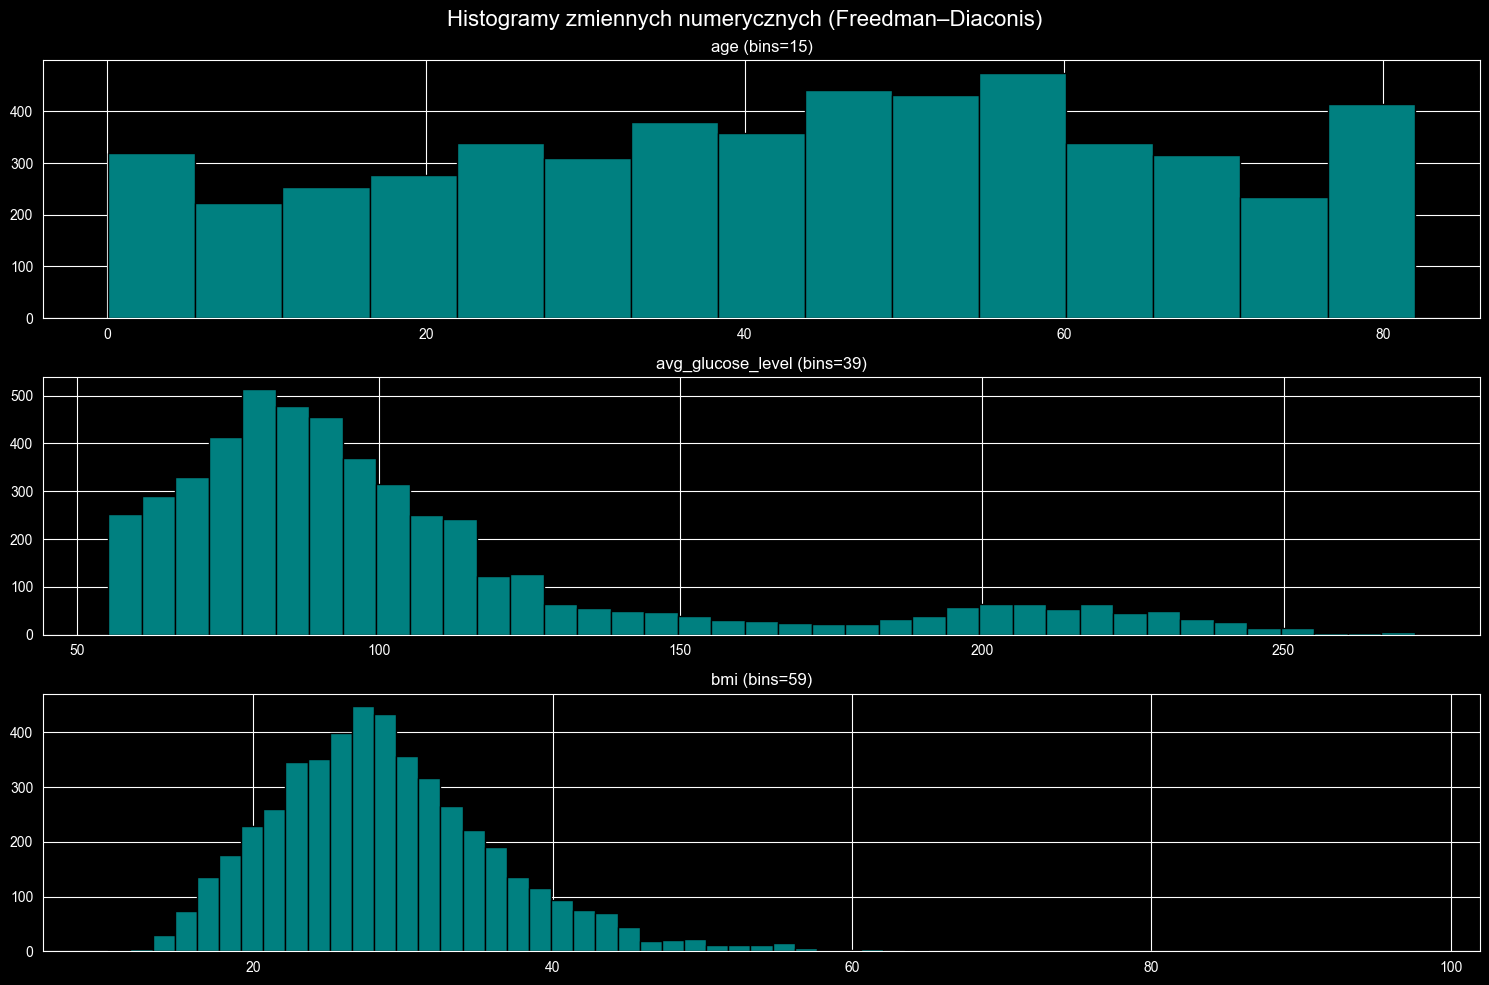

In [647]:
n_cols = 1
n_rows = int(np.ceil(len(numerical_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, numerical_features):
    x = data[col].dropna()
    bins = freedman_diaconis_bins(x)

    ax.hist(x, bins=bins, color="teal", edgecolor="black")
    ax.set_title(f"{col} (bins={bins})")

# usuwamy puste osie jeśli ich zostało za dużo
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Histogramy zmiennych numerycznych (Freedman–Diaconis)", fontsize=16)
plt.tight_layout()
plt.show()

In [648]:
bmi_median = data['bmi'].median()
bmi_mean = data['bmi'].mean()
print(bmi_median, bmi_mean)

data['bmi'] = data['bmi'].fillna(bmi_median)

28.1 28.893236911794666


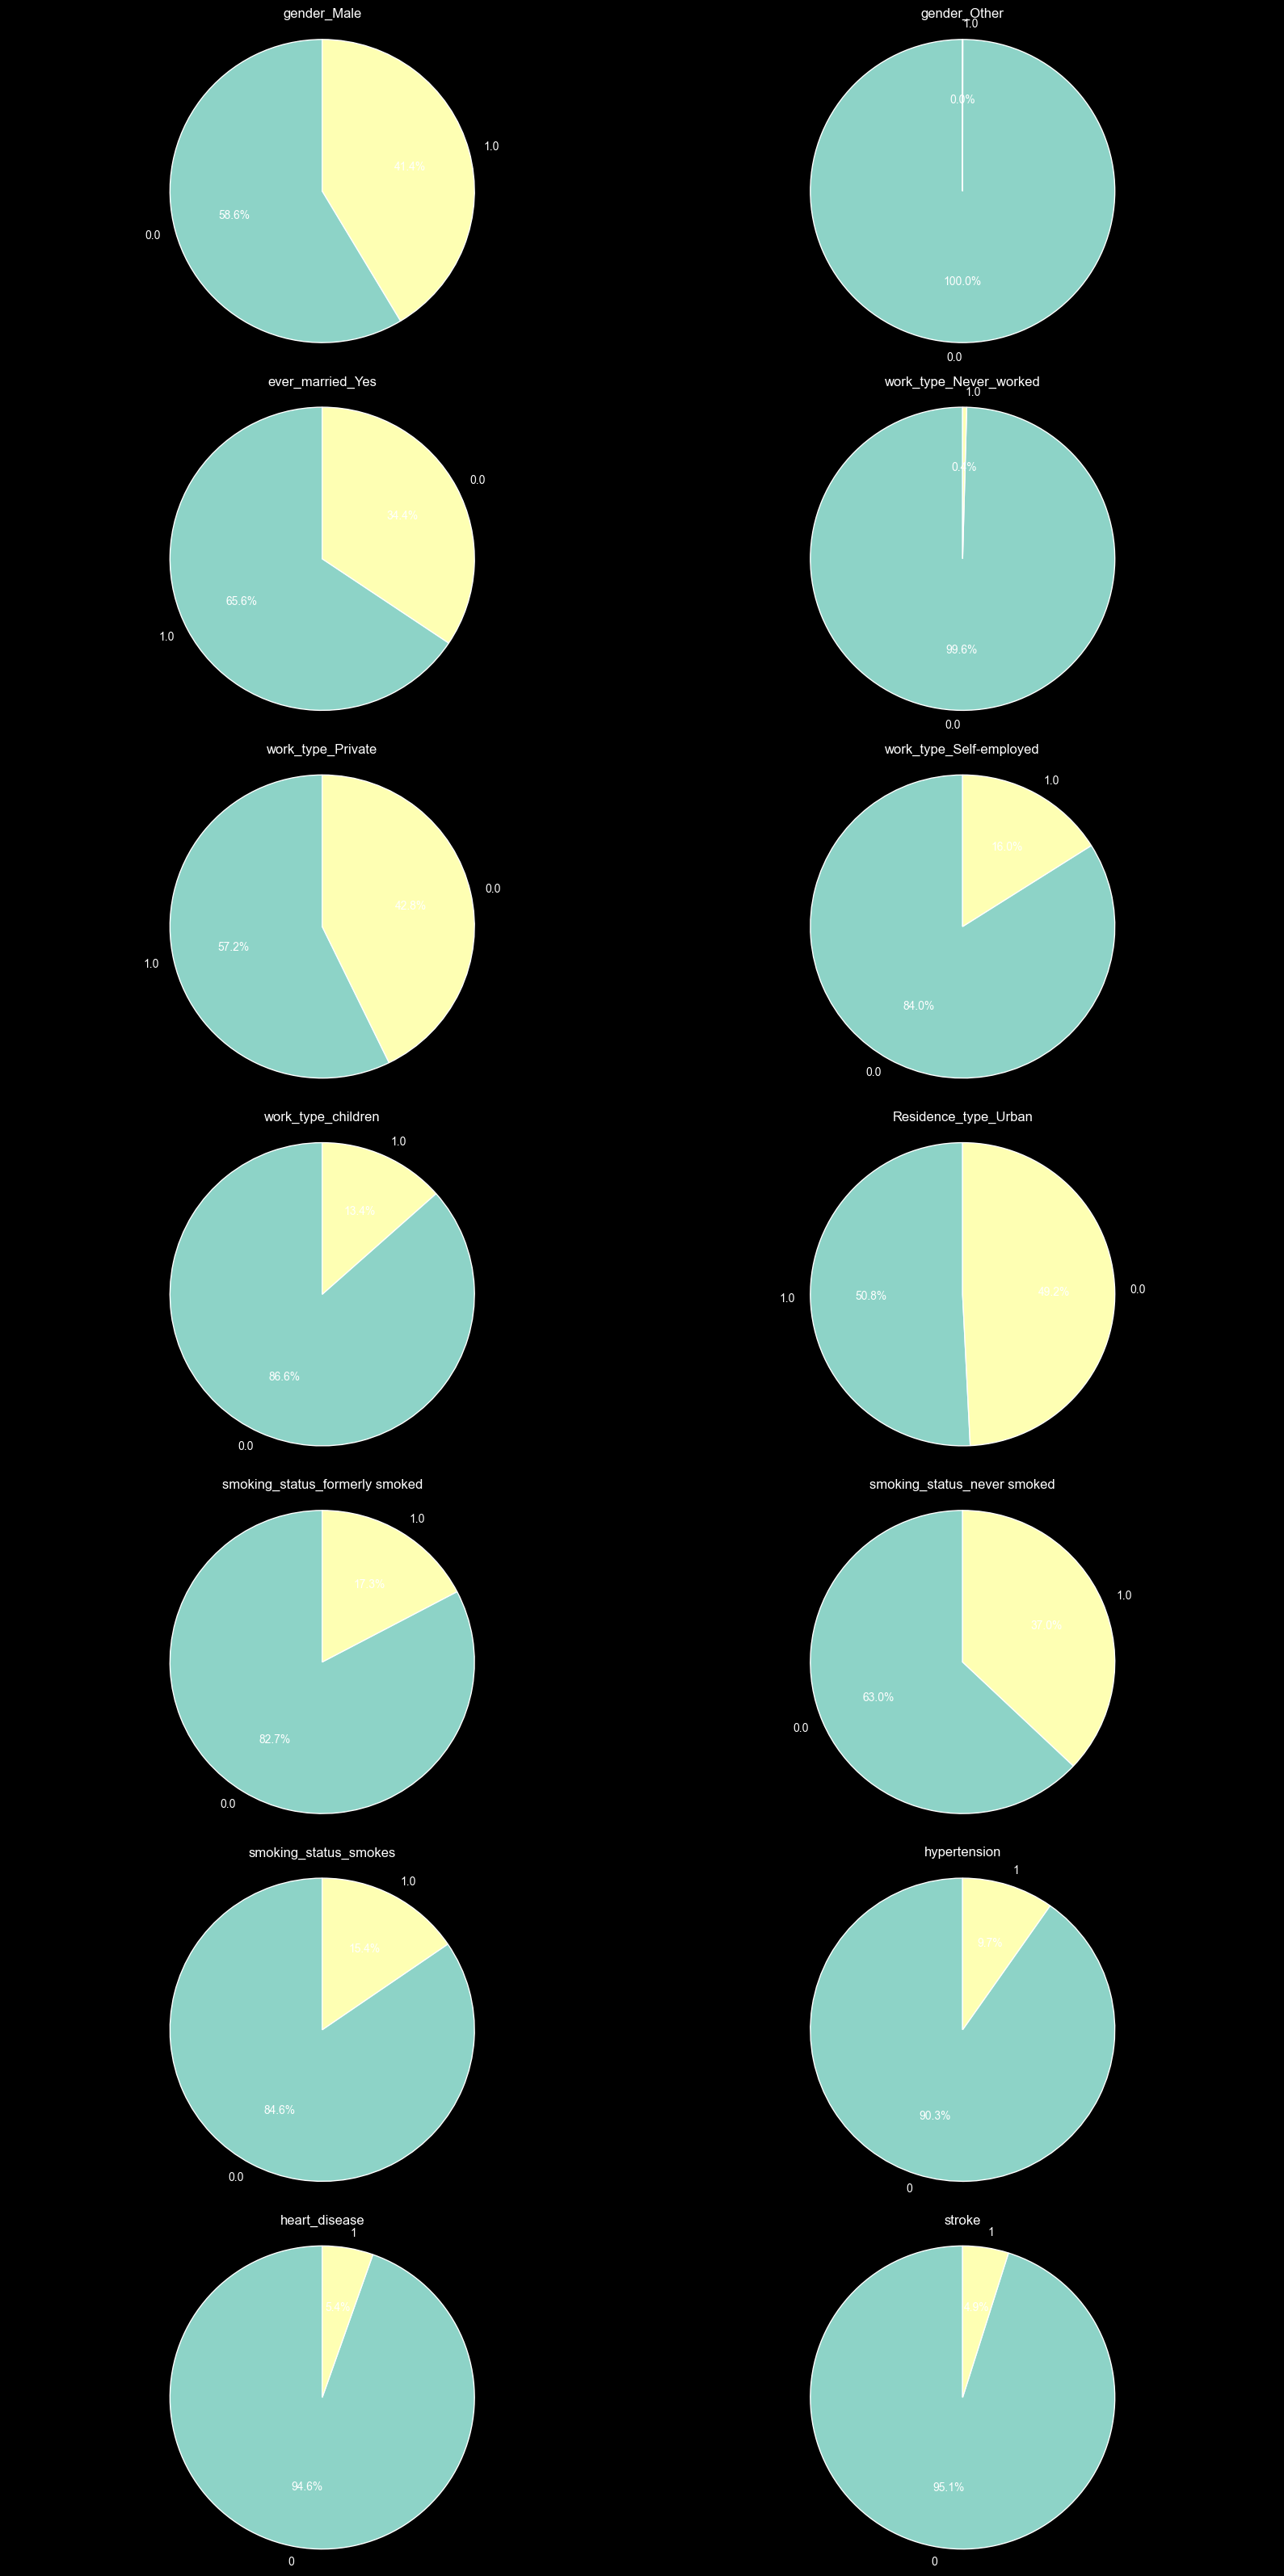

In [666]:
nrows, ncols = 7, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 32))
axes = axes.flat

for ax, col in zip(axes, categorical_features):
    sizes = data[col].value_counts()
    labels = sizes.index.astype(str)

    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(col)
    ax.axis("equal")

plt.tight_layout()
plt.show()

{'name': 'g-bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  "name": name,


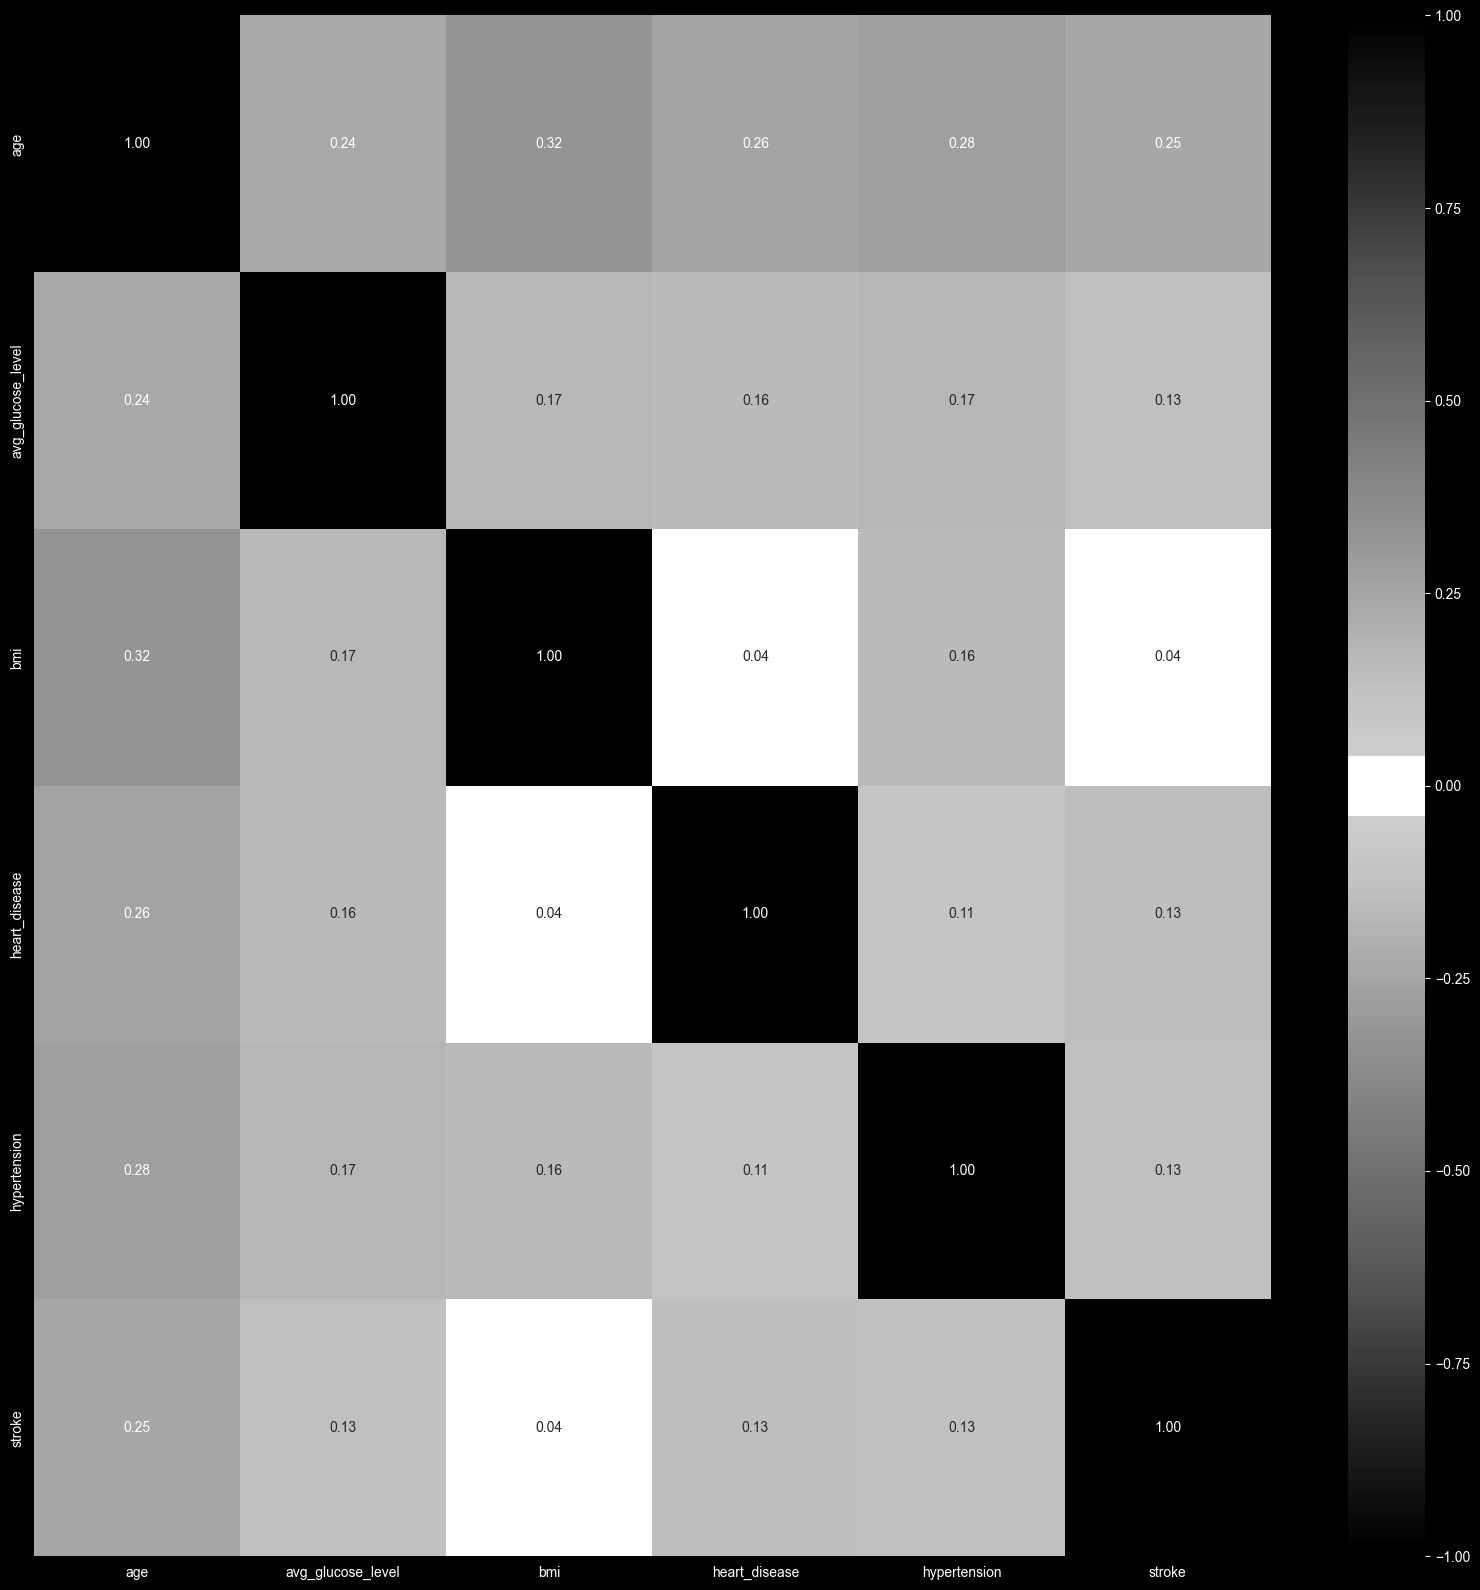

In [650]:
correlation_data = data[numerical_binary_features].corr()

n_features = data[numerical_binary_features].shape[1]
n = data[numerical_binary_features].size/data[numerical_binary_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b
plt.tight_layout()
plt.show()

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  "name": name,


{'name': 'g-bajon', 'alpha_eff': 0.03333333333333333, 'df': 5108.0, 't_crit': 2.1286212008717875, 'r_crit': 0.02977010764334429, 'steps': 8, 'side_left': 124, 'side_right': 124, 'N': 5110.0}


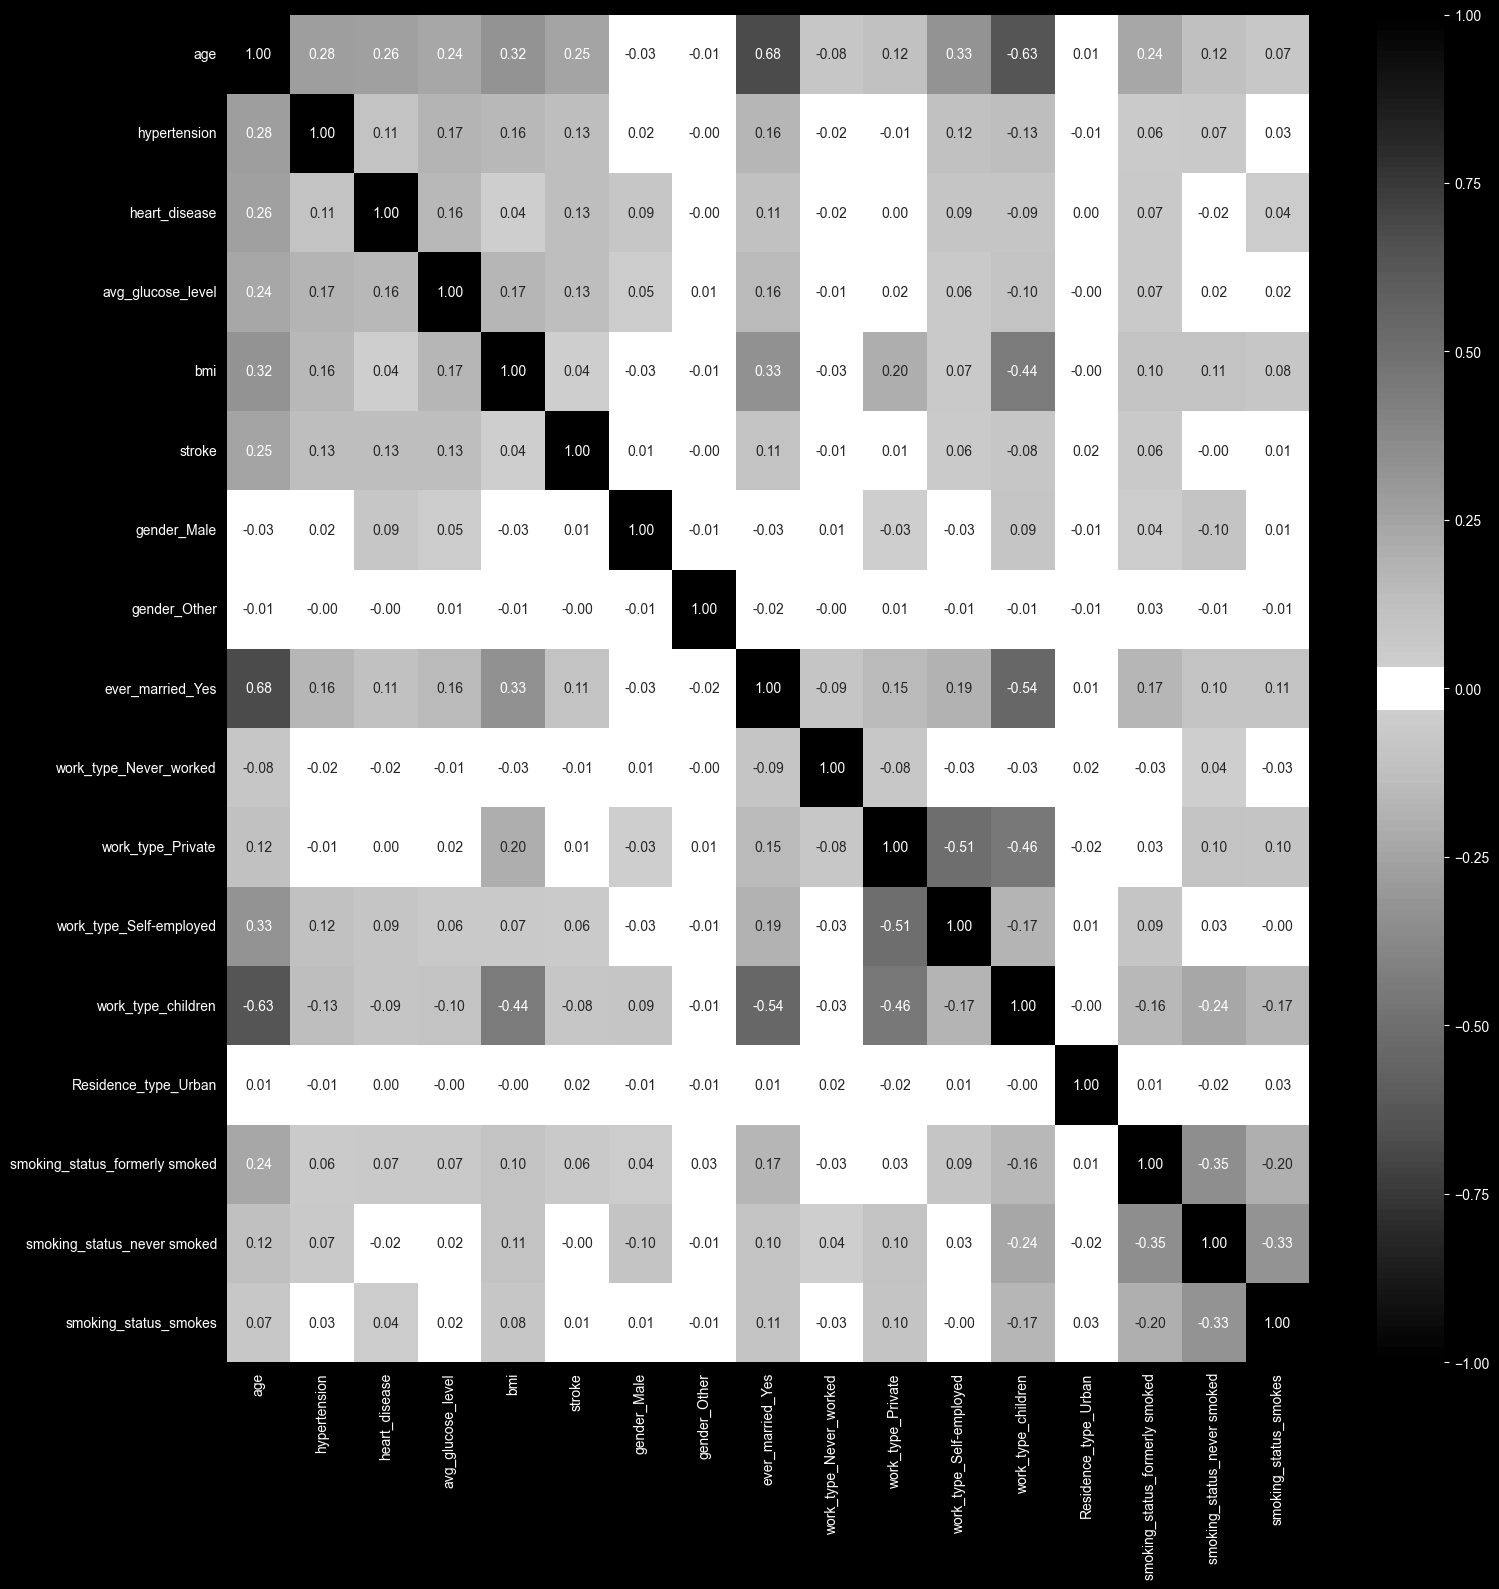

In [651]:
correlation_data = data.corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n , 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b #h-bajon #g-bajon
plt.tight_layout()
plt.show()

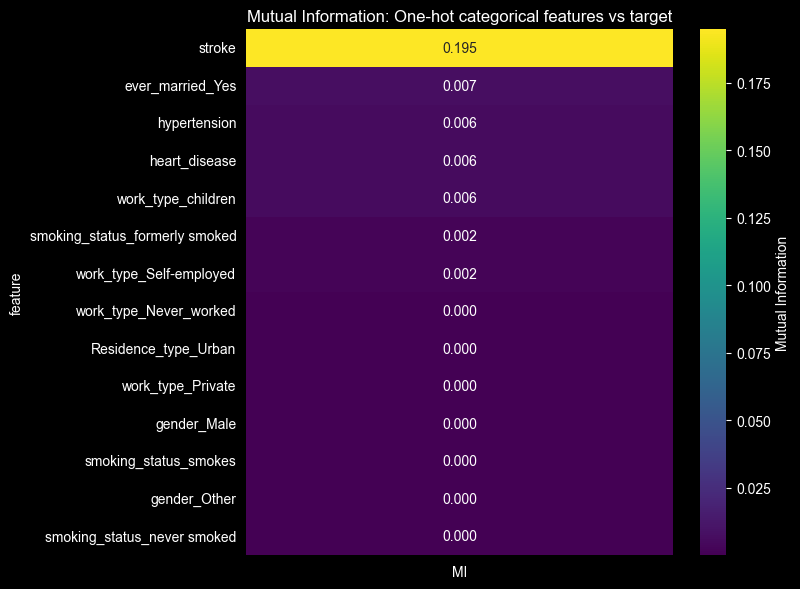

In [667]:
X_cat = data[categorical_features]
y = data[target]

mi = mutual_info_classif(
    X_cat,
    y,
    discrete_features=True,
    random_state=42
)

mi_df = (
    pd.DataFrame({
        "feature": X_cat.columns,
        "MI": mi
    })
    .sort_values("MI", ascending=False)
    .set_index("feature")
)

plt.figure(figsize=(8, max(6, len(mi_df) * 0.25)))
sns.heatmap(
    mi_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={"label": "Mutual Information"}
)
plt.title("Mutual Information: One-hot categorical features vs target")
plt.tight_layout()
plt.show()

# Feature selection

In [652]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [653]:
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced"
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # lub liczba
    max_iter=1000,
    alpha=0.05
)

boruta.fit(X_train, y_train)

selected_mask = boruta.support_
selected_features = np.where(selected_mask)[0]
print("Wybrane cechy (indeksy):", selected_features)
print("Ranking:", boruta.ranking_)

Wybrane cechy (indeksy): [0 3 4]
Ranking: [ 1  3  4  1  1  9 14  2 13 10  8 11  6  7  5 11]


In [654]:
selected_indices = np.where(boruta.support_)[0]
boruta_features = X_train.columns[selected_indices].tolist()

boruta_features

['age', 'avg_glucose_level', 'bmi']

In [655]:
corr_features = data.corr()[target].sort_values(ascending=False)
corr_features = corr_features[corr_features > custom_map.cmap_pearson(n_features, n, 0.1)['r_crit']].index.tolist()

corr_features.remove('stroke')
corr_features

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  "name": name,


['age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_formerly smoked',
 'work_type_Self-employed',
 'bmi']

In [656]:
X_chosen = data[corr_features].copy()
X_scaled = scaler.fit_transform(X_chosen)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=20
)

clusters = kmeans.fit_predict(X_scaled)
X_chosen["cluster"] = clusters

X_chosen["cluster"].describe()

count    5110.000000
mean        0.682583
std         0.919456
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         2.000000
Name: cluster, dtype: float64

In [657]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4088 entries, 1560 to 2785
Series name: stroke
Non-Null Count  Dtype
--------------  -----
4088 non-null   int64
dtypes: int64(1)
memory usage: 63.9 KB


# TODO: MUTUAL INFORMATION CATEGORICAL ISSUE

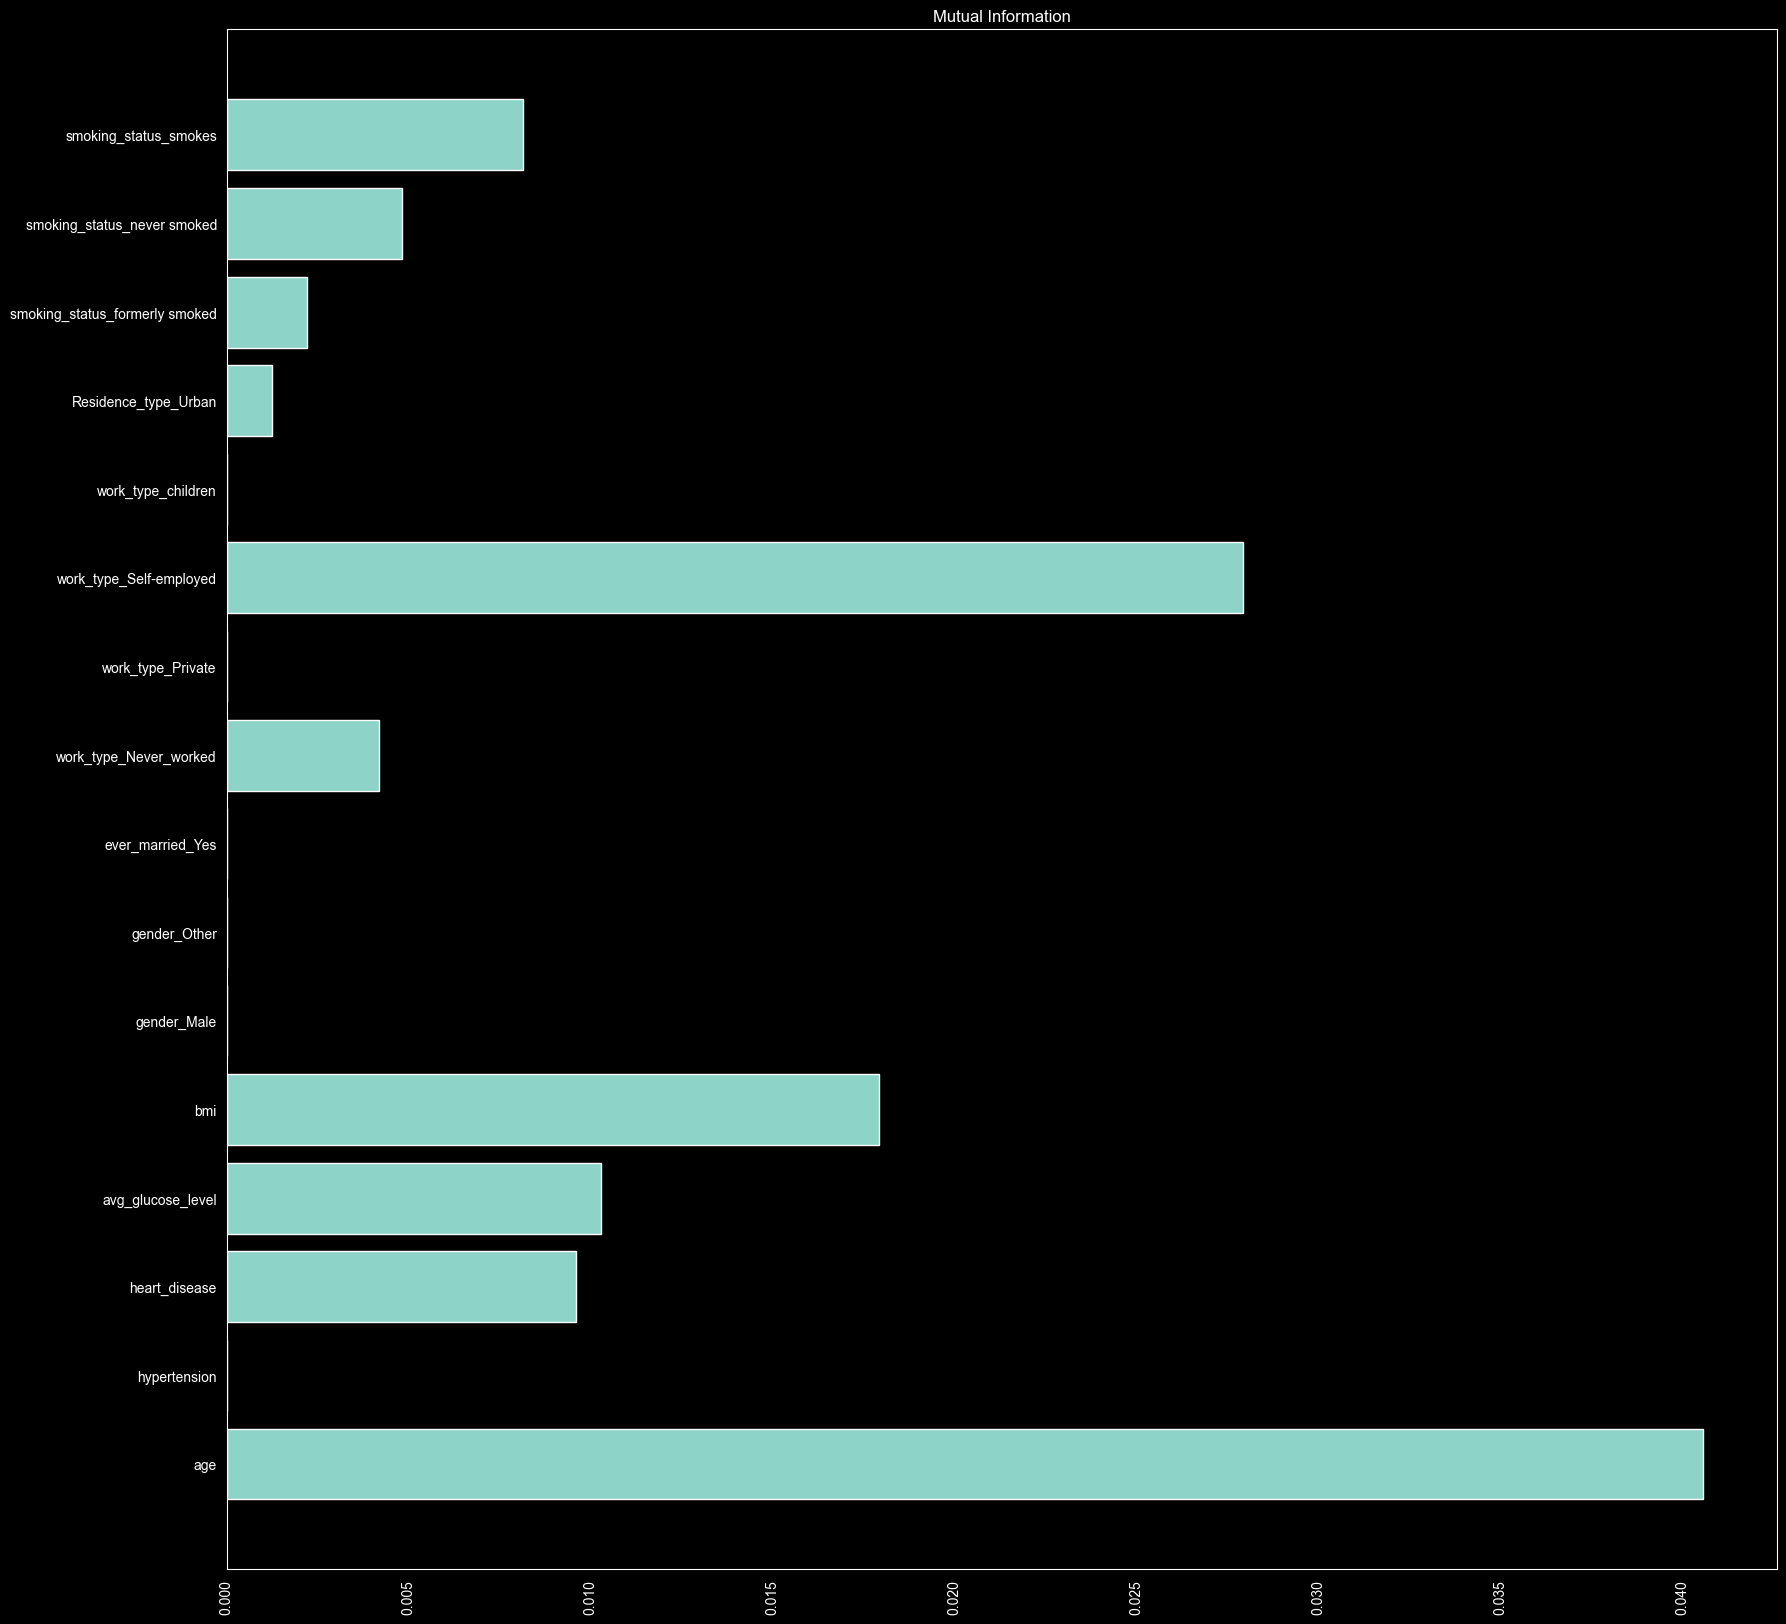

,Feature,Mutual Information
0,age,0.040555
1,hypertension,0.000000
2,heart_disease,0.009592
3,avg_glucose_level,0.010284
4,bmi,0.017928
5,gender_Male,0.000000
6,gender_Other,0.000000
7,ever_married_Yes,0.000000
8,work_type_Never_worked,0.004179
9,work_type_Private,0.000000


In [658]:
sample_idx = np.random.choice(len(X_train), size=int(X_train.size/20), replace=False)

mi = mutual_info_regression(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
mi_df = pd.DataFrame({"Feature": X_train.columns, "Mutual Information": mi})

plt.figure(figsize=(20, 20))
plt.barh(X_train.columns, mi)
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Mutual Information')
plt.show()
mi_df



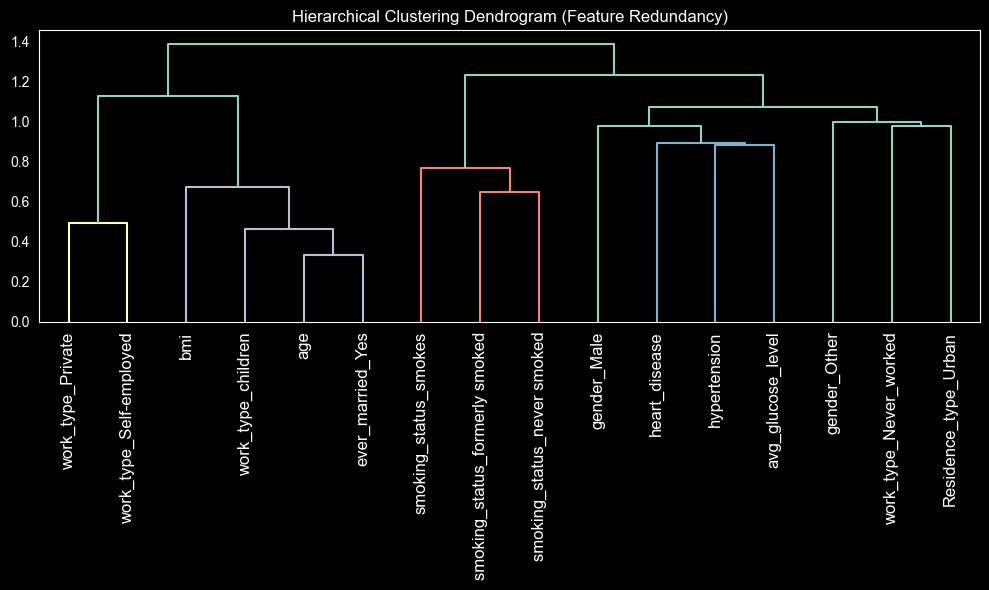

Original features: 16
Reduced features: 5
Selected: Index(['age', 'hypertension', 'gender_Other', 'work_type_Private',
       'smoking_status_formerly smoked'],
      dtype='object')


In [659]:
names = X_train.columns
# 1. Compute Spearman correlation and d
# istance matrix
# Assuming X is your dataframe of explanatory variables
corr = spearmanr(X).correlation
# Ensure the matrix is symmetric (sometimes float errors occur)
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation to a distance matrix
dist_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(hierarchy.distance.squareform(dist_matrix))

# 2. Visualize the Dendrogram
fig, ax = plt.subplots(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=names, ax=ax, leaf_rotation=90
)
ax.set_title("Hierarchical Clustering Dendrogram (Feature Redundancy)")
plt.tight_layout()
plt.grid(False)
plt.show()

# 3. Select Features
# Threshold '1' is common for 1 - abs(corr), but you can adjust based on the plot
cluster_ids = hierarchy.fcluster(dist_linkage, t=1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Keep only the first feature from each cluster
selected_idx = [v[0] for v in cluster_id_to_feature_ids.values()]
mi_features = names[selected_idx]
X_reduced = X_train.iloc[:, selected_idx]


print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(mi_features)}")
print(f"Selected: {mi_features}")

In [660]:
def stability_rfecv(X, y, n_runs=10, threshold=0.7, random_state=42):
    feature_names = np.array(X.columns)
    selection_counts = np.zeros(len(feature_names))

    for i in range(n_runs):
        seed = random_state + i

        model = LogisticRegression(
            solver="liblinear",
            class_weight="balanced",
            max_iter=10000
        )

        cv = StratifiedKFold(5, shuffle=True, random_state=seed)

        rfecv = RFECV(
            estimator=model,
            cv=cv,
            scoring="roc_auc",
            step=1,
            min_features_to_select=3
        )

        rfecv.fit(X, y)

        selection_counts += rfecv.support_.astype(int)

    freq = selection_counts / n_runs

    freq_table = pd.DataFrame({
        "feature": feature_names,
        "frequency": freq
    }).sort_values("frequency", ascending=False)

    stable_features = freq_table.loc[
        freq_table["frequency"] >= threshold, "feature"
    ].tolist()

    return stable_features, freq_table

In [661]:
stable_features, freq_table = stability_rfecv(
    X_train,
    y_train,
    n_runs=10,
    threshold=0.7
)

print("Stabilne cechy:")
print(stable_features)

freq_table.head(15)


Stabilne cechy:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,feature,frequency
0,age,1.0
1,hypertension,1.0
2,heart_disease,1.0
3,avg_glucose_level,1.0
4,bmi,1.0
5,gender_Male,1.0
6,gender_Other,1.0
7,ever_married_Yes,1.0
8,work_type_Never_worked,1.0
9,work_type_Private,1.0


## Chosen features lists

In [662]:
## hard coding because of stochasticity

all_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "gender_Male", "gender_Other", "ever_married_Yes",
                "work_type_Never_worked", "work_type_Private", "work_type_Self-employed",
                "work_type_children", "Residence_type_Urban",
                "smoking_status_formerly smoked", "smoking_status_never smoked",
                "smoking_status_smokes"]

boruta_features = ["age", "avg_glucose_level", "bmi"]

corr_features = ['age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'ever_married_Yes',
                 'smoking_status_formerly smoked', 'work_type_Self-employed', 'bmi']

mi_features = ["age", "hypertension", "gender_Other",
               "work_type_Private", "smoking_status_formerly smoked"]

rfe_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'gender_Male', 'ever_married_Yes',
                'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children',
                'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes',
                'bmi']

FEATURE_SETS = {
    "all": all_features,
    "boruta": boruta_features,
    "correlation": corr_features,
    "mi": mi_features,
    "rfe": rfe_features
}